In [1]:
from sklearn.neighbors import KernelDensity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
from projects.ephys.population import Population

In [2]:
hffm = Population(savepath='/home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm')
hffm.load(fname='hffm_031822')
hffm.exptype = 'hffm'

reading from /home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm/hffm_031822.pickle


In [3]:
hffm.data['session'].unique()

array(['062921_G6HCK1ALTRN_control_Rig2', '070921_J553RT_control_Rig2',
       '101521_J559NC_control_Rig2', '102621_J558NC_control_Rig2',
       '110321_J558LT_control_Rig2', '110421_J569LT_control_Rig2',
       '122021_J581RT_control_Rig2', '020222_J577TT_control_Rig2',
       '020422_J577RT_control_Rig2'], dtype=object)

In [4]:
data = hffm.data[hffm.data['session']=='070921_J553RT_control_Rig2']

In [6]:
stim = 'FmLt'
eyeT = data[stim+'_eyeT'].iloc[0]
dEye = data[stim+'_dEye_dps'].iloc[0]
dHead = data[stim+'_dHead'].iloc[0]
dGaze = data[stim+'_dGaze'].iloc[0]

# gaze-shift dHead
left_gaze_dHead = eyeT[(np.append(dHead, 0) > hffm.low_sacc_thresh) & (np.append(dGaze, 0) > hffm.low_sacc_thresh)]
right_gaze_dHead = eyeT[(np.append(dHead, 0) < -hffm.low_sacc_thresh) & (np.append(dGaze, 0) < -hffm.low_sacc_thresh)]

# comp dHead
left_comp_dHead = eyeT[(np.append(dHead,0) > hffm.low_sacc_thresh) & (np.append(dGaze, 0) < hffm.gaze_sacc_thresh)]
right_comp_dHead = eyeT[(np.append(dHead,0) < -hffm.low_sacc_thresh) & (np.append(dGaze,0) > -hffm.gaze_sacc_thresh)]
left_comp_dHead = hffm.apply_win_to_comp_sacc(left_comp_dHead, left_gaze_dHead)
right_comp_dHead = hffm.apply_win_to_comp_sacc(right_comp_dHead, right_gaze_dHead)

In [25]:
def calc_kde_sdf(spikeT, eventT, bandwidth=10, resample_size=1, edgedrop=15, win=1000):
    """
    bandwidth (in msec)
    resample_size (msec)
    edgedrop (msec to drop at the start and end of the window so eliminate artifacts of filtering)
    win = 1000msec before and after
    """
    # some conversions
    bandwidth = bandwidth/1000 # msec to sec
    resample_size = resample_size/1000 # msec to sec
    win = win/1000 # msec to sec
    edgedrop = edgedrop/1000
    edgedrop_ind = int(edgedrop/resample_size)

    # setup time bins
    bins = np.arange(-win-edgedrop, win+edgedrop+resample_size, resample_size)

    # get timestamp of spikes relative to events in eventT
    sps = []
    for i, t in enumerate(eventT):
        sp = spikeT-t
        sp = sp[(sp <= (win+edgedrop)) & (sp >= (-win-edgedrop))] # only keep spikes in this window
        sps.extend(sp)
    sps = np.array(sps) # all values in here are between -1 and 1

    # kernel density estimation
    kernel = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sps[:,np.newaxis])
    density = kernel.score_samples(bins[:,np.newaxis])
    sdf = np.exp(density)*(np.size(sps)/np.size(eventT)) # convert back to spike rate
    sdf = sdf[edgedrop_ind:-edgedrop_ind]
    bins = bins[edgedrop_ind:-edgedrop_ind]

    return bins, sdf

In [29]:
from tqdm import tqdm

In [26]:
bins, sdf = calc_kde_sdf(data['FmLt_spikeT'].iloc[0], left_comp_dHead)

20it [01:56,  5.80s/it]


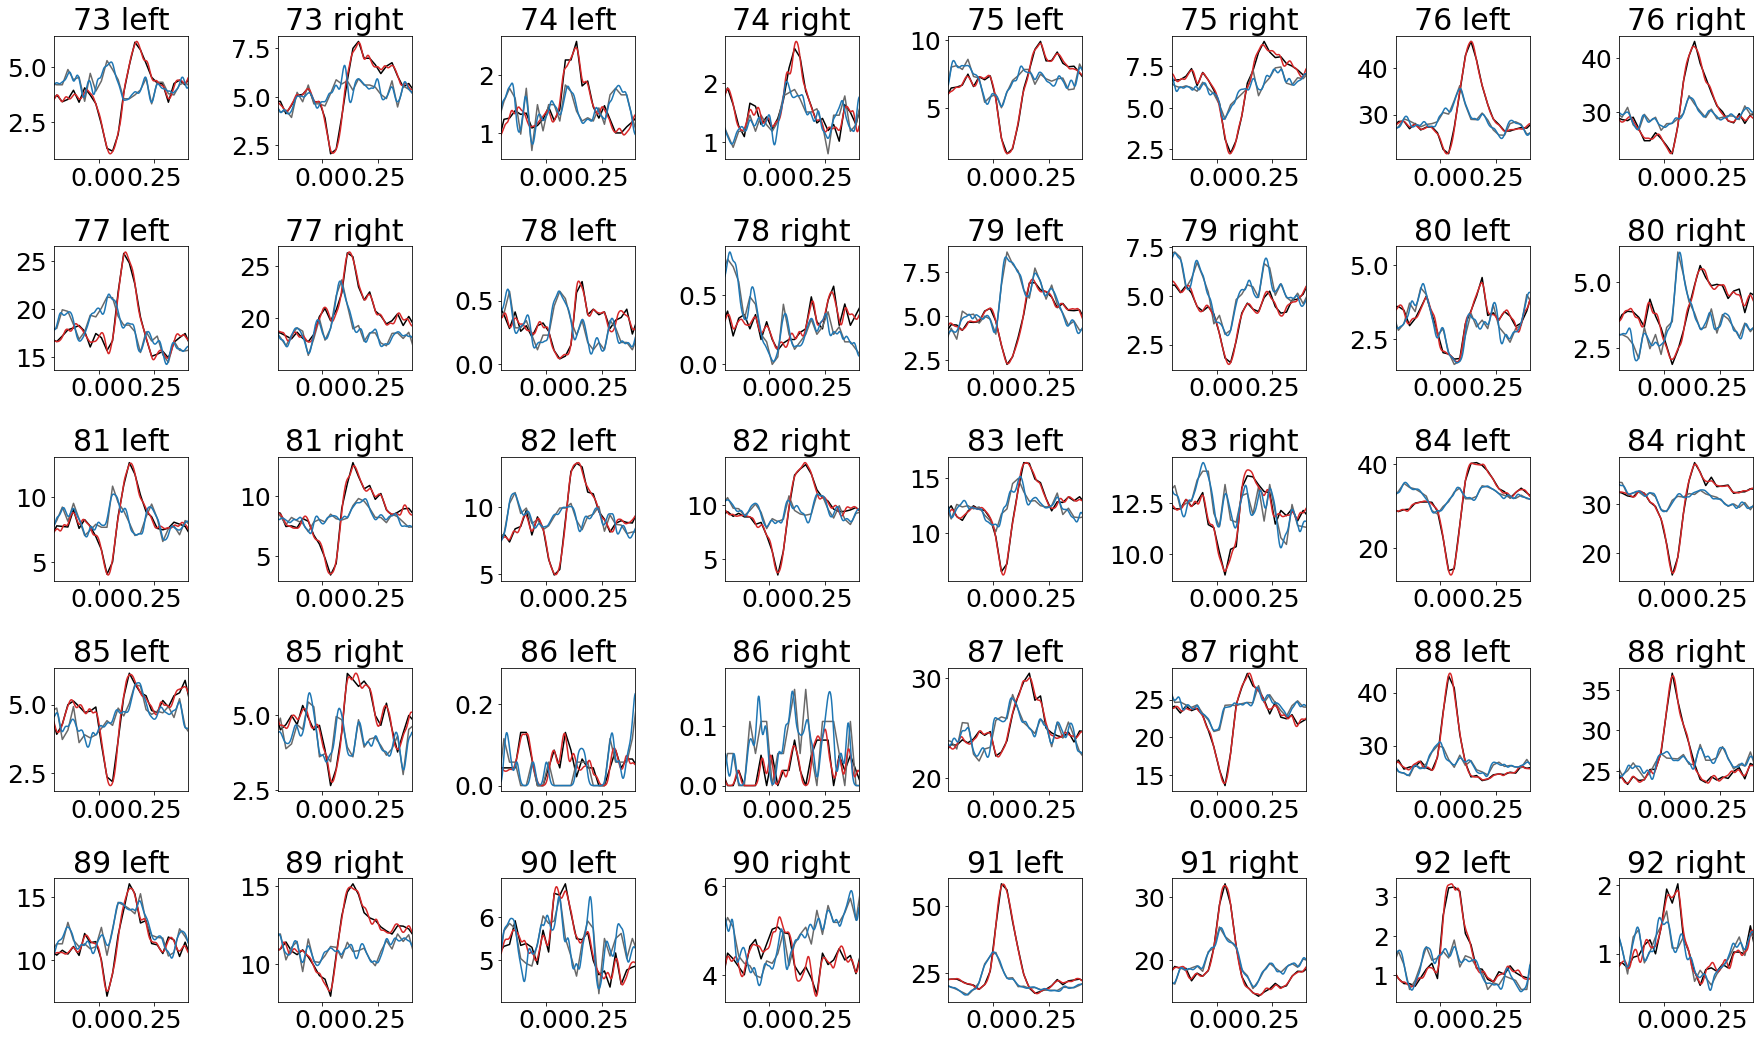

In [41]:
plt.subplots(5,8,figsize=(25,15))
panelnum = 1
for i, ind in tqdm(enumerate(data.index.values[:20])):
    spikeT = data.loc[ind, 'FmLt_spikeT']
    
    plt.subplot(5,8,panelnum)
    plt.plot(hffm.trange_x, hffm.calc_psth(spikeT, left_gaze_dHead), color='k')
    plt.plot(hffm.trange_x, hffm.calc_psth(spikeT, left_comp_dHead), color='dimgrey')
    plt.plot(bins, calc_kde_sdf(spikeT, left_gaze_dHead)[1], color='tab:red')
    plt.plot(bins, calc_kde_sdf(spikeT, left_comp_dHead)[1], color='tab:blue')
    plt.title('{} left'.format(ind))
    plt.xlim([-0.2,0.4])
    panelnum += 1
    
    plt.subplot(5,8,panelnum)
    plt.plot(hffm.trange_x, hffm.calc_psth(spikeT, right_gaze_dHead), color='k')
    plt.plot(hffm.trange_x, hffm.calc_psth(spikeT, right_comp_dHead), color='dimgrey')
    plt.plot(bins, calc_kde_sdf(spikeT, right_gaze_dHead)[1], color='tab:red')
    plt.plot(bins, calc_kde_sdf(spikeT, right_comp_dHead)[1], color='tab:blue')
    plt.title('{} right'.format(ind))
    plt.xlim([-0.2,0.4])
    panelnum += 1
    
plt.tight_layout()

In [ ]:
# 86, 91

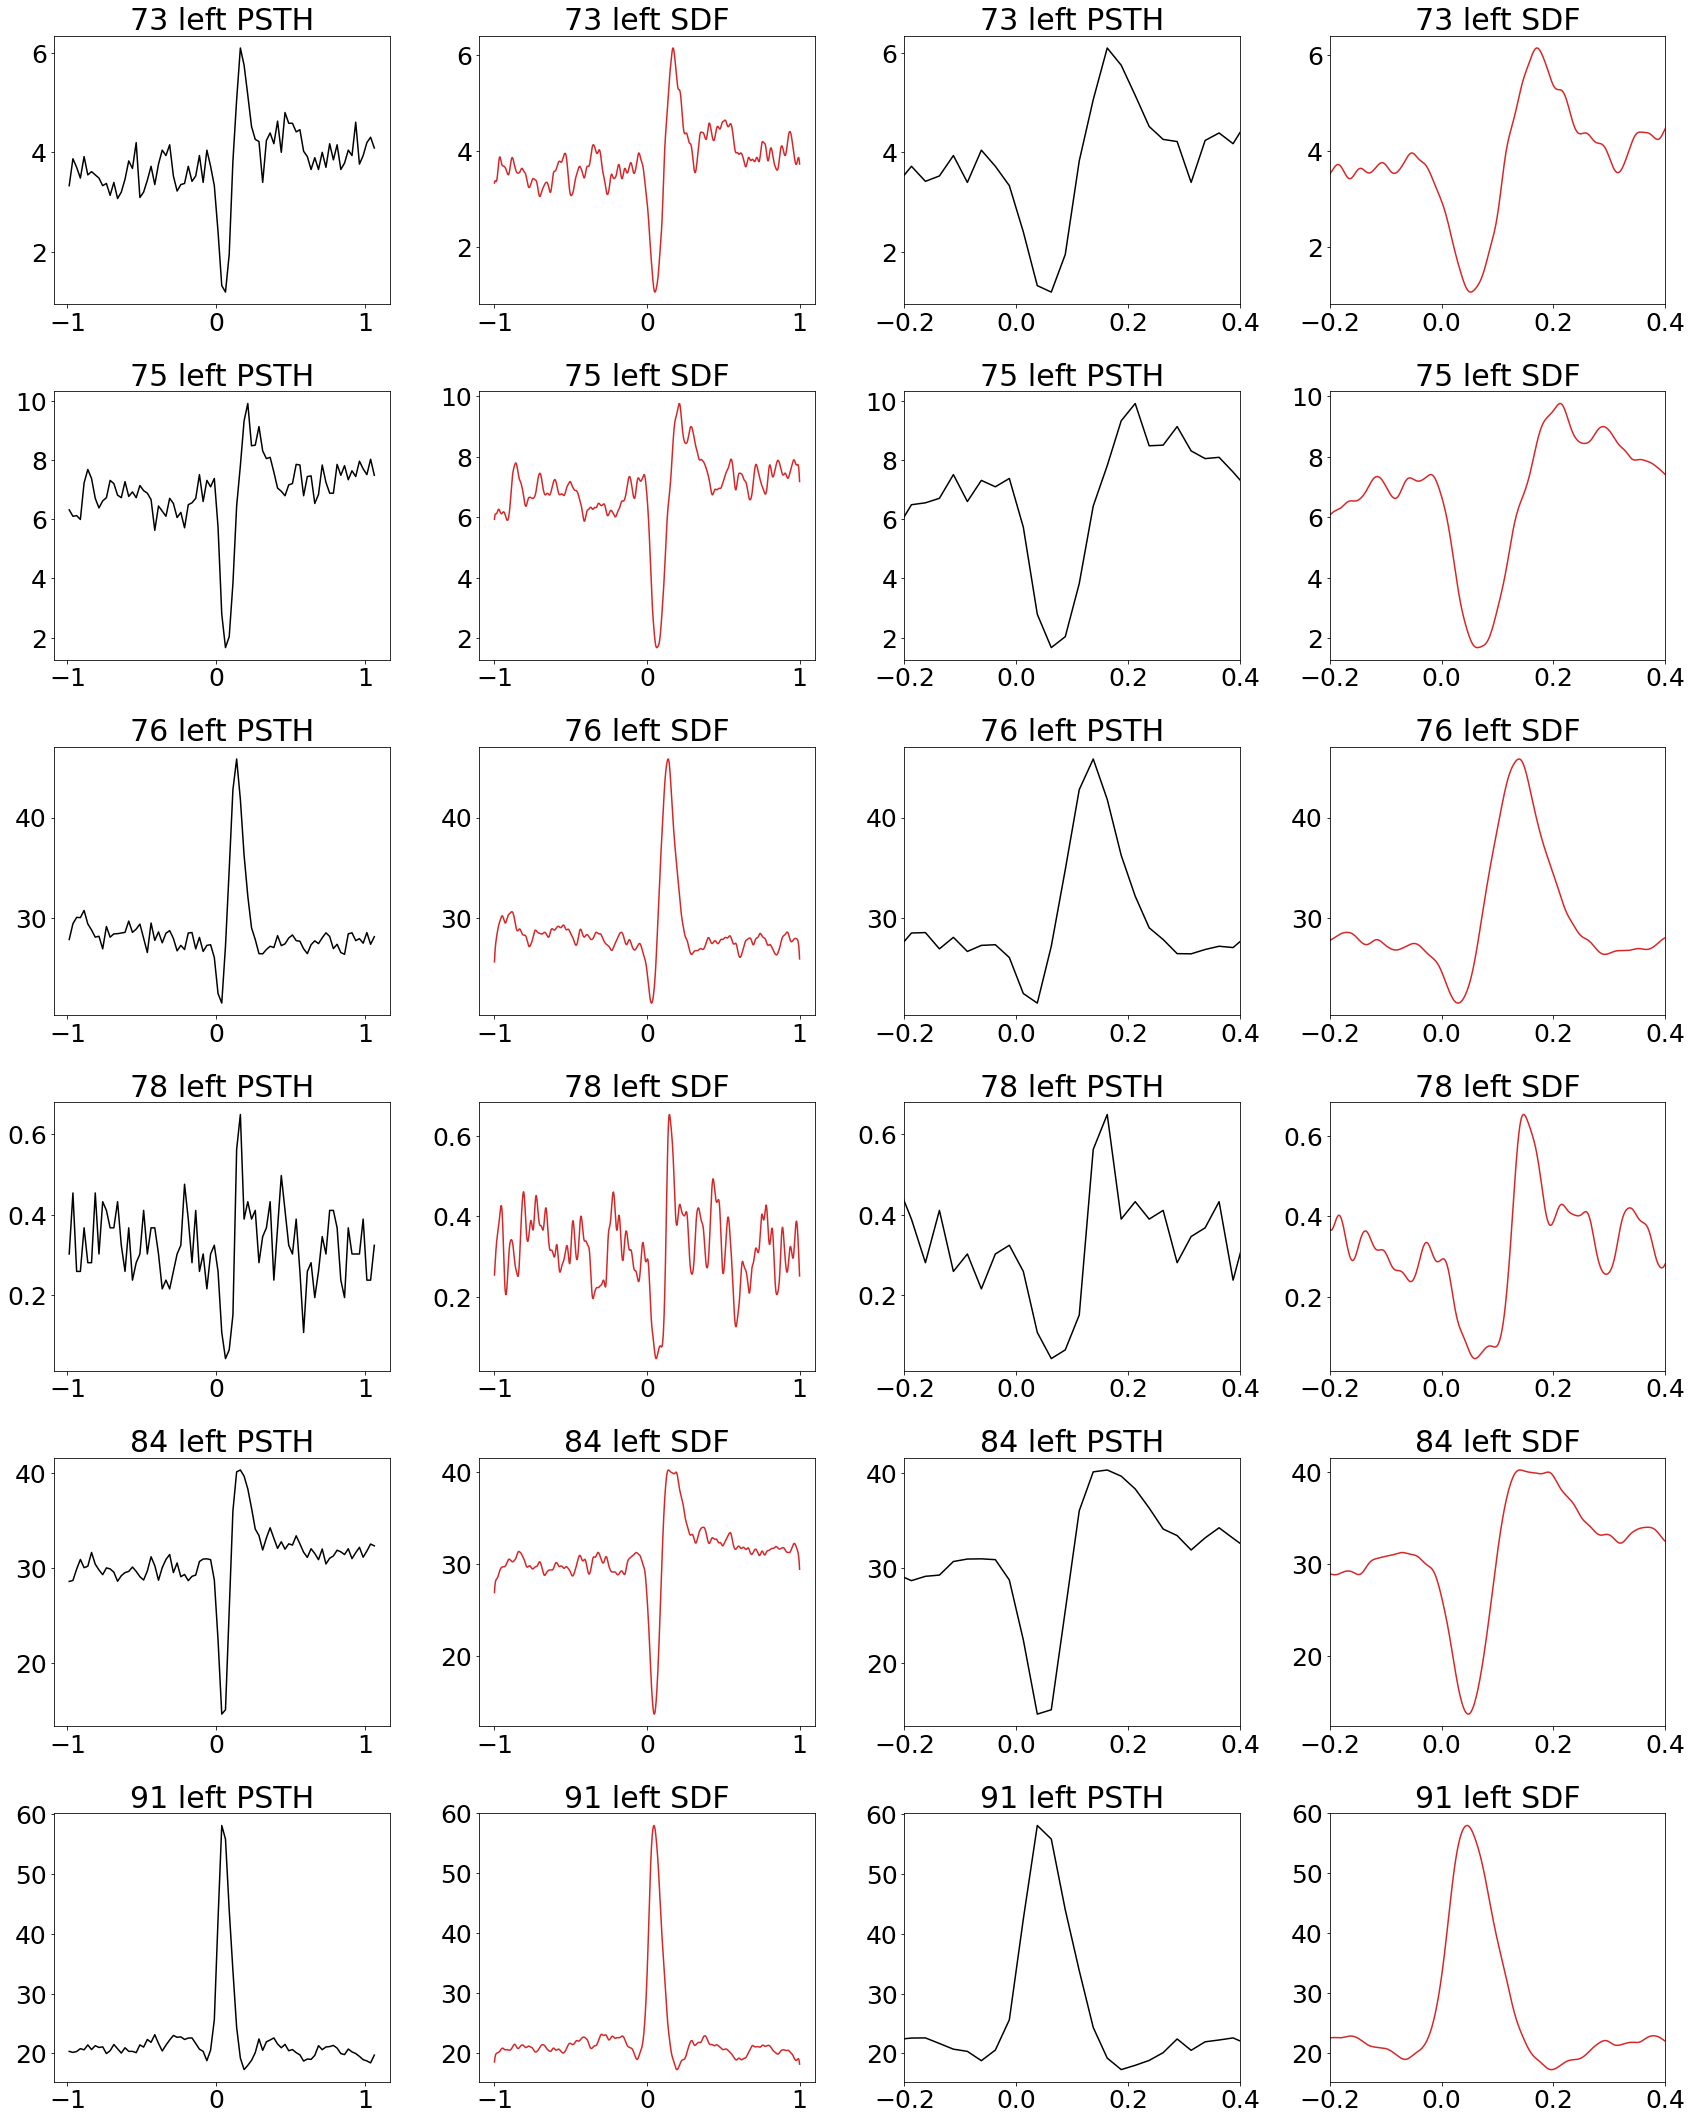

In [55]:
units = [73,75,76,78,84,91]
plt.subplots(6,4,figsize=(24,30))
panelnum = 1
for ind in units:
    spikeT = hffm.data['FmLt_spikeT'].iloc[ind]
    
    plt.subplot(6,4,panelnum)
    plt.plot(hffm.trange_x, hffm.calc_psth(spikeT, left_gaze_dHead), color='k')
    plt.title('{} left PSTH'.format(ind))
#     plt.xlim([-0.2,0.4])
    panelnum += 1
    
    plt.subplot(6,4,panelnum)
    plt.plot(bins, calc_kde_sdf(spikeT, left_gaze_dHead)[1], color='tab:red')
    plt.title('{} left SDF'.format(ind))
#     plt.xlim([-0.2,0.4])
    panelnum += 1
    
    plt.subplot(6,4,panelnum)
    plt.plot(hffm.trange_x, hffm.calc_psth(spikeT, left_gaze_dHead), color='k')
    plt.title('{} left PSTH'.format(ind))
    plt.xlim([-0.2,0.4])
    panelnum += 1
    
    plt.subplot(6,4,panelnum)
    plt.plot(bins, calc_kde_sdf(spikeT, left_gaze_dHead)[1], color='tab:red')
    plt.title('{} left SDF'.format(ind))
    plt.xlim([-0.2,0.4])
    panelnum += 1
    
plt.tight_layout()